#1. Ejercicio de clasificación con algoritmo Naive Bayes
#Urban Land Cover Data Set

Number of instances 168

Number of Attributes 148

Contiene datos de entrenamiento y prueba para clasificar una imagen aérea de alta resolución en 9 tipos de cobertura de suelo urbano. Para la clasificación se utiliza información espectral, de tamaño, forma y textura de múltiples escalas. 
 El conjunto de datos de prueba proviene de una muestra aleatoria de la imagen.

Las clases de cobertura terrestre son:


* Árboles
* Césped
* Suelo
* Concreto
* Asfalto
* Edificios
* Coches
* Piscinas
* Sombras





#2. Importación de librerías y montando google drive

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from collections import Counter
import itertools

# 3. Lectura y visualuzación del dataset




In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.4 Naive Bayes'
train_path = os.path.join(path,'training.csv')
test_path = os.path.join(path,'testing.csv')


In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
clases = train_df['label'].unique()
train_df.dropna(axis=0, inplace=True)
train_df


,label,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Bright_40,Compact_40,ShpIndx_40,Mean_G_40,Mean_R_40,Mean_NIR_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,...,Round_120,Bright_120,Compact_120,ShpIndx_120,Mean_G_120,Mean_R_120,Mean_NIR_120,SD_G_120,SD_R_120,SD_NIR_120,LW_120,GLCM1_120,Rect_120,GLCM2_120,Dens_120,Assym_120,NDVI_120,BordLngth_120,GLCM3_120,BrdIndx_140,Area_140,Round_140,Bright_140,Compact_140,ShpIndx_140,Mean_G_140,Mean_R_140,Mean_NIR_140,SD_G_140,SD_R_140,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,21.41,20.40,18.69,2.19,0.48,0.87,6.23,1.60,0.74,-0.08,56,4219.69,1.33,97,1.12,227.19,1.32,1.42,203.95,237.23,240.38,27.63,28.36,26.18,2.00,0.50,0.85,6.29,1.67,0.70,...,1.12,227.19,1.32,1.42,203.95,237.23,240.38,27.63,28.36,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36,1.33,97,1.12,227.19,1.32,1.42,203.95,237.23,240.38,27.63,28.36,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,6.57,6.97,7.02,1.52,0.45,0.63,6.35,1.55,0.69,-0.10,156,3682.08,3.01,1188,1.45,209.44,2.25,3.54,181.91,222.46,223.95,9.82,10.37,10.51,2.97,0.63,0.65,7.16,1.43,0.83,...,1.66,211.94,2.90,4.97,186.31,223.83,225.68,22.62,22.92,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14,4.57,7711,1.66,211.94,2.90,4.97,186.31,223.83,225.68,22.62,22.92,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,6.16,4.93,5.53,1.14,0.52,0.78,6.19,1.88,0.19,-0.08,144,2943.35,2.32,1095,1.50,232.50,1.93,2.55,208.36,244.07,245.08,6.55,7.01,6.83,2.19,0.49,0.74,6.51,1.61,0.81,...,1.17,222.97,1.87,2.08,201.51,232.96,234.43,15.35,15.93,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04,1.93,4606,1.17,222.97,1.87,2.08,201.51,232.96,234.43,15.35,15.93,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,5.76,5.56,5.46,2.51,0.50,0.74,6.28,1.51,0.83,-0.09,218,3550.19,3.16,4009,2.28,231.57,3.48,3.47,204.77,245.17,244.76,9.55,9.35,9.34,2.27,0.63,0.62,7.04,1.32,0.84,...,1.41,226.65,2.06,2.88,200.18,239.93,239.83,13.69,13.75,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38,2.41,10482,1.41,226.65,2.06,2.88,200.18,239.93,239.83,13.69,13.75,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,11.46,8.90,9.77,12.26,0.71,0.59,7.36,0.63,0.99,-0.11,504,2300.41,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,11.46,8.90,9.77,12.26,0.71,0.59,7.36,0.63,0.99,...,2.37,193.39,5.03,12.06,172.13,203.14,204.91,17.38,14.93,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38,3.34,16680,2.37,193.39,5.03,12.06,172.13,203.14,204.91,17.38,14.93,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,car,1.43,39,1.41,234.03,1.54,1.60,206.36,246.05,249.69,15.48,12.95,11.83,1.67,0.26,0.75,5.47,1.40,0.60,-0.09,40,6040.96,1.53,60,1.22,221.55,1.52,1.68,194.53,232.85,237.27,22.72,25.11,24.00,1.86,0.51,0.74,5.96,1.62,0.48,...,0.65,173.48,1.36,1.33,148.64,182.88,188.92,52.05,57.01,55.92,1.73,0.65,0.81,7.05,1.89,0.42,-0.10,66,2469.69,1.22,154,0.65,173.48,1.36,1.33,148.64,182.88,188.92,52.05,57.01,55.92,1.73,0.65,0.81,7.05,1.89,0.42,-0.10,66,2469.69
164,soil,1.92,141,1.24,215.19,2.02,2.02,212.28,216.28,217.00,6.82,9.12,9.72,1.27,0.37,0.78,6.24,1.79,0.46,-0.01,96,3873.35,1.71,263,0.97,209.50,1.91,1.85,207.80,210.34,210.36,8.23,10.70,11.37,1.76,0.58,0

##Balance de clases 

In [ ]:
print(train_df['label'].value_counts())

grass        29
building     25
concrete     23
tree         17
shadow       16
car          15
pool         15
asphalt      14
soil         14
Name: label, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


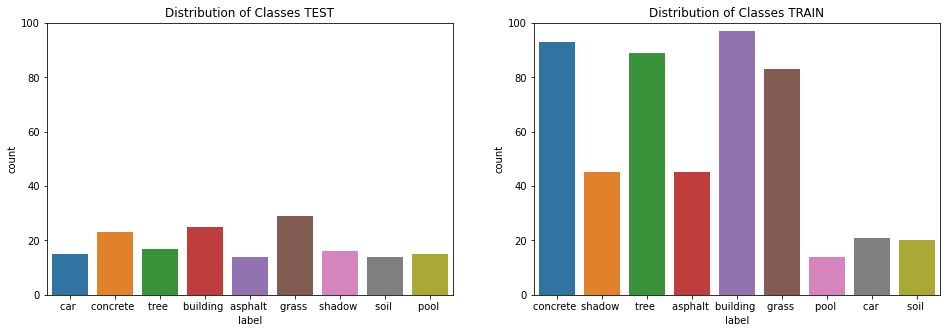

In [ ]:
f,ax=plt.subplots(1,2,figsize=(16,5))

sns.countplot('label',data=train_df,ax=ax[0])
ax[0].set_title('Distribution of Classes TRAIN')

sns.countplot('label',data=test_df,ax=ax[1])
ax[1].set_title('Distribution of Classes TEST')

ax[0].set_ylim(0,100)
ax[1].set_ylim(0,100)

plt.show()

In [ ]:
print ('Conteo de valores faltantes: \n')
print (train_df.isna().sum().sum())

Conteo de valores faltantes: 

0


#4. Escalamiento

In [ ]:
scaler =StandardScaler()
train_df.loc[:, train_df.columns != 'label'] = scaler.fit_transform(train_df.loc[:, train_df.columns != 'label'])
test_df.loc[:, test_df.columns != 'label'] = scaler.transform(test_df.loc[:, test_df.columns != 'label'])


#5. Codificación de etiquetas

In [ ]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)
test_df['label'] = le.fit_transform(test_df.label.values)

In [ ]:
test_df

,label,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Compact_40,ShpIndx_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,BordLngth_40,GLCM3_40,BrdIndx_60,Area_60,...,Area_80,Round_80,Bright_80,Compact_80,ShpIndx_80,Mean_G_80,Mean_R_80,Mean_NIR_80,SD_G_80,SD_R_80,SD_NIR_80,LW_80,GLCM1_80,Rect_80,GLCM2_80,Dens_80,Assym_80,BordLngth_80,GLCM3_80,BrdIndx_100,Area_100,Round_100,Bright_100,Compact_100,ShpIndx_100,Mean_G_100,Mean_R_100,Mean_NIR_100,SD_G_100,SD_R_100,SD_NIR_100,LW_100,GLCM1_100,Rect_100,GLCM2_100,Dens_100,Assym_100,NDVI_100,BordLngth_100,GLCM3_100
0,3,-1.087842,-0.641564,-0.662254,0.926590,-0.598810,-0.071109,0.496106,1.004830,1.013566,0.214686,0.425312,0.390634,3.396012,-0.797598,0.247820,0.386195,-2.425828,1.675068,-0.530240,-0.815035,1.342215,-1.175015,-0.877948,-0.844648,-0.595905,-0.368319,-0.365538,-0.234573,-0.246892,2.171380,-1.505963,0.361055,-0.724258,-2.013590,1.549554,-1.069981,2.147361,-1.222594,-0.785890,...,-0.463622,1.846463,0.359555,2.378941,0.585921,-0.007657,0.516376,0.462124,1.332866,1.619548,1.606676,-0.497627,-0.079663,-2.498142,1.500531,-0.928987,-1.727592,-0.115882,0.192585,0.703320,-0.646195,1.590255,0.361659,2.026214,0.376046,-0.034032,0.524185,0.480507,0.896155,1.328886,1.363629,-0.364419,-0.394750,-2.158069,1.115987,-0.853224,-1.580622,-0.753129,-0.353781,0.555417
1,6,-0.661245,0.439834,-0.395693,-1.912653,-0.957226,-0.513035,-1.973436,-1.616059,-1.687575,-0.383691,-0.266959,-0.191240,0.475589,-0.797598,0.783548,0.641632,0.497829,0.603338,-0.749110,0.295025,0.284670,-1.484081,0.075880,-1.482200,-1.289859,-1.301202,-0.655769,-0.425326,-0.333866,0.435494,-0.950982,1.654692,-0.042961,0.092125,0.989622,-0.634185,0.792630,-1.352025,-0.341184,...,-0.507771,-1.394493,-1.867169,-1.061848,-1.208343,-1.958641,-1.595411,-1.661128,-0.843670,-0.648847,-0.605843,0.290428,-1.836224,1.550485,-0.742629,0.186794,0.909770,-0.788783,1.462206,-1.396178,-0.682033,-1.454956,-1.906590,-1.076105,-1.251947,-2.074806,-1.618678,-1.677571,-0.950805,-0.800535,-0.761440,0.165351,-2.320996,1.607592,-0.975045,0.203511,0.989558,-0.946889,-0.908486,1.918013
2,6,-0.945643,-0.231430,-0.272664,-1.850740,-1.014572,-0.997728,-1.895927,-1.571330,-1.637553,-0.391437,-0.030182,0.061309,-0.156316,-0.011485,0.860080,0.084316,0.528932,0.438457,-0.584957,-0.593023,-0.265016,-0.621273,-0.126281,1.159087,-0.376762,-0.587821,-0.450189,-0.318504,-0.207816,-0.002353,-1.089727,0.145449,-0.106833,-0.381661,1.075766,-0.334575,0.368320,0.222716,0.355441,...,-0.043750,0.833664,-1.922319,0.272335,-0.095445,-1.939779,-1.668283,-1.755356,-0.456692,-0.657887,-0.581404,0.250566,-0.748829,-0.592906,-0.581251,-1.045214,1.202811,-0.069841,-0.329186,-0.395254,-0.305365,0.638627,-1.962769,0.126835,-0.242179,-2.055076,-1.692623,-1.773344,-0.622424,-0.809022,-0.737967,0.138553,-1.128558,-0.385993,-0.824611,-0.963301,1.275134,-0.494781,-0.315827,-0.004563
3,8,0.902946,-0.558947,1.593267,-1.547659,1.910099,1.254670,-1.082712,-1.525756,-1.616305,3.576440,1.310215,1.168486,0.578060,1.346345,-1.895092,1.872370,-1.928184,1.262864,1.439594,-0.167500,-0.664233,0.808154,-0.300343,1.723776,1.449434,1.552323,3.362720,1.746714,1.787544,1.036080,1.338312,-1.579401,3.363521,-1.960947,1.377267,0.582412,-1.174674,0.578651,-0.584450,...,-0.661835,1.151973,-1.181775,0.709261,0.767618,-0.651976,-1.272949,-1.327418,1.957985,0.597127,0.646234,0.765715,0.840441,-1.128753,1.758737,-1.672840,1.286536,-0.314210,-0.617607,-0.492905,-0.612087,0.162813,-1.561219,-0.281180,0.053195,-1.248230,-1.515126,-1.585775,1.861983,0.342100,0.463839,0.707488,1.072867,0.167780,1.356681,-1.095392,1.397523,1.249063,-0.429688,-0.852169
4,0,0.934545,-0.663694,1.880334,-1.231773,1.408317,1.126369,-1.398443,-0.967483,-1.044973,-0.914290,-0.832816,-0.815542,0.048626,-0.797598,-1.206299,-1.053537,-1.306129,0.974322,-0.694393,-0.537520,1.971542,2.301969,-0.589145,1.9

## 6. Selección de características por análisis de correlación (Coeficiente de Pearson)

In [ ]:
#todas con todas
correlations = train_df.corr().abs().unstack().sort_values(kind="quicksort").reset_index() 
correlations

,level_0,level_1,0
0,SD_R,GLCM1_60,0.000052
1,GLCM1_60,SD_R,0.000052
2,BordLngth,Mean_NIR,0.000162
3,Mean_NIR,BordLngth,0.000162
4,NDVI,Area_100,0.000220
...,...,...,...
9020,LW_80,LW_80,1.000000
9021,GLCM1_80,GLCM1_80,1.000000
9022,Rect_80,Rect_80,1.000000
9023,ShpIndx_80,ShpIndx_80,1.000000


In [ ]:
#remueve las que son consigo mismas
correlations = correlations[correlations['level_0'] != correlations['level_1']] 
correlations

,level_0,level_1,0
0,SD_R,GLCM1_60,0.000052
1,GLCM1_60,SD_R,0.000052
2,BordLngth,Mean_NIR,0.000162
3,Mean_NIR,BordLngth,0.000162
4,NDVI,Area_100,0.000220
...,...,...,...
8925,Bright_100,Bright_80,0.986813
8926,Mean_NIR_80,Mean_NIR_100,0.987327
8927,Mean_NIR_100,Mean_NIR_80,0.987327
8928,Mean_R_80,Mean_R_100,0.987394


In [ ]:
#identificar las que tienen correlación mayor a 0.99
correlations = correlations.loc[correlations[0] >= 0.99]  
#correlations

In [ ]:
removable_features = set(list(correlations['level_1']))
len(removable_features)
#removable_features

0

Eliminar las removable features a los conjuntos de train y test

In [ ]:
train_df = train_df.drop(removable_features, axis=1)
train_df

,label,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Compact_40,ShpIndx_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,BordLngth_40,GLCM3_40,BrdIndx_60,Area_60,...,Area_80,Round_80,Bright_80,Compact_80,ShpIndx_80,Mean_G_80,Mean_R_80,Mean_NIR_80,SD_G_80,SD_R_80,SD_NIR_80,LW_80,GLCM1_80,Rect_80,GLCM2_80,Dens_80,Assym_80,BordLngth_80,GLCM3_80,BrdIndx_100,Area_100,Round_100,Bright_100,Compact_100,ShpIndx_100,Mean_G_100,Mean_R_100,Mean_NIR_100,SD_G_100,SD_R_100,SD_NIR_100,LW_100,GLCM1_100,Rect_100,GLCM2_100,Dens_100,Assym_100,NDVI_100,BordLngth_100,GLCM3_100
0,2,-1.166842,-0.700576,-0.334178,1.066623,-0.985899,-1.083262,0.733063,1.098086,1.077458,2.184100,2.217191,1.895829,-0.013995,-0.440274,0.936613,-0.565885,-0.155329,0.644559,-0.420804,-1.222057,1.232549,-1.162138,-0.904486,-0.279959,-1.009843,-1.202427,1.616497,1.913305,1.636285,-0.223213,-1.020355,0.864136,-1.469426,0.092125,0.300476,-1.269721,1.592069,-1.071592,-0.956561,...,-0.897499,-0.439569,1.142693,-0.866792,-1.132635,0.796741,1.188084,1.171962,0.693738,0.704793,0.548480,-0.230853,-2.003515,0.895560,-1.904554,0.140303,0.239964,-1.036694,3.135836,-1.184600,-0.998395,-0.557706,1.159401,-0.900237,-1.183255,0.807385,1.205778,1.201987,0.353805,0.470174,0.347257,-0.185081,-2.504448,0.998441,-2.058169,0.159480,0.336814,-0.559368,-1.112851,3.714203
1,3,0.555348,-0.479281,0.875601,0.819782,0.548120,0.399329,0.415591,0.924373,0.881505,-0.689657,-0.477650,-0.461973,-0.395415,-0.654668,-0.900169,-0.287228,-0.310842,0.438457,-0.530240,-0.297007,0.658920,1.001319,-0.052910,0.321161,0.122399,1.124294,-0.537258,-0.374459,-0.338907,0.152637,-0.118511,-0.573239,0.382849,-0.539589,0.860407,0.691361,0.274360,2.379895,0.853031,...,0.760978,0.732385,0.775136,0.576623,1.668535,0.378434,0.895998,0.853122,-0.074091,0.012769,0.013272,-0.151128,0.003983,-1.307369,1.080947,-0.766269,0.574867,1.566372,0.145818,1.541492,0.347873,0.543464,0.784989,0.401189,1.358337,0.369827,0.909394,0.877918,-0.297757,-0.179454,-0.166796,-0.131485,-0.303023,-1.050522,0.724859,-0.699117,0.663186,-0.688542,1.032981,0.505226
2,3,0.176150,-0.442398,0.691059,1.079590,-0.011008,-0.028342,0.711234,1.132969,1.096787,-0.769053,-0.886993,-0.763012,-0.611742,-0.154415,0.247820,-0.658771,0.715548,-1.622561,-0.420804,-0.408013,-0.129304,0.112757,-0.125501,0.412240,-0.267190,0.037760,-0.932698,-0.801745,-0.802769,-0.149593,-1.089727,0.073580,-1.001034,-0.065804,0.774264,0.010430,0.819076,-0.295007,1.096778,...,0.402915,-0.222540,1.095688,-0.351844,-0.526977,0.778379,1.146934,1.102465,-0.581015,-0.536249,-0.526009,-0.172593,0.087629,0.062019,-0.500561,0.000830,0.742319,-0.098174,-0.602500,-0.696345,0.116039,-0.489733,1.086455,-0.513326,-0.729890,0.764782,1.140944,1.107328,-0.558531,-0.488837,-0.481332,-0.145915,-0.119571,0.389290,-0.629047,0.181495,0.785576,-0.494781,-0.368378,-0.534669
3,3,0.650147,-0.246183,0.301469,1.050740,0.591130,0.712954,0.680546,1.119607,1.060341,-0.846513,-0.760579,-0.777155,0.168176,-0.297344,-0.058311,-0.449778,-0.435253,1.015542,-0.475522,0.276524,0.518193,1.194485,2.149012,1.833071,1.619879,1.047469,-0.569909,-0.504171,-0.486385,-0.118595,-0.118511,-0.788845,0.127363,-0.829125,0.903479,2.461782,-0.142267,1.010086,1.320813,...,1.393678,0.703447,1.225843,0.311347,0.964457,0.822280,1.312280,1.248346,-0.811276,-0.856783,-0.822533,0.192305,-0.581537,-0.473828,-0.742629,-1.045214,1.202811,1.456582,0.185593,0.581256,0.861466,0.516275,1.244101,0.162008,0.719505,0.834100,1.331802,1.279624,-0.923317,-0.995732,-0.969565,0.099387,-0.945106,-0.275239,-0.975045,-0.963301,1.275134,-0.623955,0.942477,0.547913
4,3,0.223550,0.557858,1.224182,0.447494,0.290061,2.665982,0.069646,0.589043,0.539177,0.257289,-0.090380,0.093636,5.718688,1.203416,-1.206299,2.058142,-3.172293,1.675068,-0.584957,2.922166,-0.815320,-0.106165,-0.243363,0.831203,0.158923,1.738900,-0.338934,-0.561396,-0.4

In [ ]:
test_df = test_df.drop(removable_features, axis=1)
test_df

,label,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,SD_G,SD_R,SD_NIR,LW,GLCM1,Rect,GLCM2,Dens,Assym,NDVI,BordLngth,GLCM3,BrdIndx_40,Area_40,Round_40,Compact_40,ShpIndx_40,SD_G_40,SD_R_40,SD_NIR_40,LW_40,GLCM1_40,Rect_40,GLCM2_40,Dens_40,Assym_40,BordLngth_40,GLCM3_40,BrdIndx_60,Area_60,...,Area_80,Round_80,Bright_80,Compact_80,ShpIndx_80,Mean_G_80,Mean_R_80,Mean_NIR_80,SD_G_80,SD_R_80,SD_NIR_80,LW_80,GLCM1_80,Rect_80,GLCM2_80,Dens_80,Assym_80,BordLngth_80,GLCM3_80,BrdIndx_100,Area_100,Round_100,Bright_100,Compact_100,ShpIndx_100,Mean_G_100,Mean_R_100,Mean_NIR_100,SD_G_100,SD_R_100,SD_NIR_100,LW_100,GLCM1_100,Rect_100,GLCM2_100,Dens_100,Assym_100,NDVI_100,BordLngth_100,GLCM3_100
0,3,-1.087842,-0.641564,-0.662254,0.926590,-0.598810,-0.071109,0.496106,1.004830,1.013566,0.214686,0.425312,0.390634,3.396012,-0.797598,0.247820,0.386195,-2.425828,1.675068,-0.530240,-0.815035,1.342215,-1.175015,-0.877948,-0.844648,-0.595905,-0.368319,-0.365538,-0.234573,-0.246892,2.171380,-1.505963,0.361055,-0.724258,-2.013590,1.549554,-1.069981,2.147361,-1.222594,-0.785890,...,-0.463622,1.846463,0.359555,2.378941,0.585921,-0.007657,0.516376,0.462124,1.332866,1.619548,1.606676,-0.497627,-0.079663,-2.498142,1.500531,-0.928987,-1.727592,-0.115882,0.192585,0.703320,-0.646195,1.590255,0.361659,2.026214,0.376046,-0.034032,0.524185,0.480507,0.896155,1.328886,1.363629,-0.364419,-0.394750,-2.158069,1.115987,-0.853224,-1.580622,-0.753129,-0.353781,0.555417
1,6,-0.661245,0.439834,-0.395693,-1.912653,-0.957226,-0.513035,-1.973436,-1.616059,-1.687575,-0.383691,-0.266959,-0.191240,0.475589,-0.797598,0.783548,0.641632,0.497829,0.603338,-0.749110,0.295025,0.284670,-1.484081,0.075880,-1.482200,-1.289859,-1.301202,-0.655769,-0.425326,-0.333866,0.435494,-0.950982,1.654692,-0.042961,0.092125,0.989622,-0.634185,0.792630,-1.352025,-0.341184,...,-0.507771,-1.394493,-1.867169,-1.061848,-1.208343,-1.958641,-1.595411,-1.661128,-0.843670,-0.648847,-0.605843,0.290428,-1.836224,1.550485,-0.742629,0.186794,0.909770,-0.788783,1.462206,-1.396178,-0.682033,-1.454956,-1.906590,-1.076105,-1.251947,-2.074806,-1.618678,-1.677571,-0.950805,-0.800535,-0.761440,0.165351,-2.320996,1.607592,-0.975045,0.203511,0.989558,-0.946889,-0.908486,1.918013
2,6,-0.945643,-0.231430,-0.272664,-1.850740,-1.014572,-0.997728,-1.895927,-1.571330,-1.637553,-0.391437,-0.030182,0.061309,-0.156316,-0.011485,0.860080,0.084316,0.528932,0.438457,-0.584957,-0.593023,-0.265016,-0.621273,-0.126281,1.159087,-0.376762,-0.587821,-0.450189,-0.318504,-0.207816,-0.002353,-1.089727,0.145449,-0.106833,-0.381661,1.075766,-0.334575,0.368320,0.222716,0.355441,...,-0.043750,0.833664,-1.922319,0.272335,-0.095445,-1.939779,-1.668283,-1.755356,-0.456692,-0.657887,-0.581404,0.250566,-0.748829,-0.592906,-0.581251,-1.045214,1.202811,-0.069841,-0.329186,-0.395254,-0.305365,0.638627,-1.962769,0.126835,-0.242179,-2.055076,-1.692623,-1.773344,-0.622424,-0.809022,-0.737967,0.138553,-1.128558,-0.385993,-0.824611,-0.963301,1.275134,-0.494781,-0.315827,-0.004563
3,8,0.902946,-0.558947,1.593267,-1.547659,1.910099,1.254670,-1.082712,-1.525756,-1.616305,3.576440,1.310215,1.168486,0.578060,1.346345,-1.895092,1.872370,-1.928184,1.262864,1.439594,-0.167500,-0.664233,0.808154,-0.300343,1.723776,1.449434,1.552323,3.362720,1.746714,1.787544,1.036080,1.338312,-1.579401,3.363521,-1.960947,1.377267,0.582412,-1.174674,0.578651,-0.584450,...,-0.661835,1.151973,-1.181775,0.709261,0.767618,-0.651976,-1.272949,-1.327418,1.957985,0.597127,0.646234,0.765715,0.840441,-1.128753,1.758737,-1.672840,1.286536,-0.314210,-0.617607,-0.492905,-0.612087,0.162813,-1.561219,-0.281180,0.053195,-1.248230,-1.515126,-1.585775,1.861983,0.342100,0.463839,0.707488,1.072867,0.167780,1.356681,-1.095392,1.397523,1.249063,-0.429688,-0.852169
4,0,0.934545,-0.663694,1.880334,-1.231773,1.408317,1.126369,-1.398443,-0.967483,-1.044973,-0.914290,-0.832816,-0.815542,0.048626,-0.797598,-1.206299,-1.053537,-1.306129,0.974322,-0.694393,-0.537520,1.971542,2.301969,-0.589145,1.9

#7. Modelo de clasificación con Naive Bayes y k-fold CV




In [ ]:
X_train = train_df.values[:,1:]
Y_train = train_df.values[:,0]

X_test = test_df.values[:,1:]
Y_test = test_df.values[:,0]

In [ ]:
print(f'Dimension de los datos de entrenamiento {X_train.shape}')
print(f'Dimension de los datos de prueba {X_test.shape}')

Dimension de los datos de entrenamiento (168, 94)
Dimension de los datos de prueba (507, 94)


In [ ]:
seed = 42
from sklearn.naive_bayes import GaussianNB 
NB =  GaussianNB()
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [ ]:
score_train = cross_val_score(NB, X_train, Y_train, cv=kfold, scoring="accuracy")
print("Train Acc: %s"%score_train)

Train Acc: [0.94117647 0.67647059 0.85294118 0.66666667 0.78787879]


In [ ]:
y_pred = cross_val_predict(NB, X_test, Y_test, cv=10)

score = metrics.accuracy_score(Y_test, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.7869822485207101


In [ ]:
#Funciones para MC y métricas
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    #plt.grid(b=None)
    plt.show()
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  acc=[]
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    acc.append(TP/(TP+FP))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  acc.append(sum([x*y for x,y in zip(acc,pesos)]))
  return sensitivity, specificity, acc

Matriz de confusión

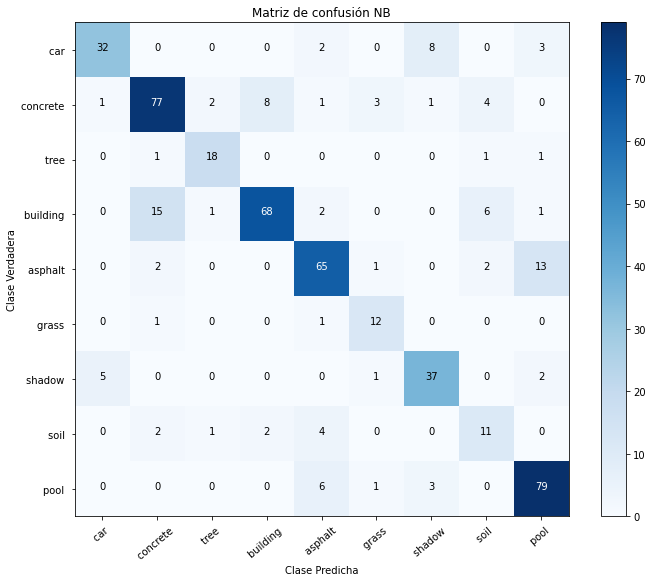

In [ ]:
n_clases = 9
predictions = np.float32(y_pred)
true_labels = np.float32(Y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión NB'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

Pesos por clase

In [ ]:
pesos = train_df['label'].value_counts().sort_index().tolist()/ np.sum(train_df['label'].value_counts().tolist())
print(clases)
print(pesos)

['car ' 'concrete ' 'tree ' 'building ' 'asphalt ' 'grass ' 'shadow '
 'soil ' 'pool ']
[0.08333333 0.14880952 0.08928571 0.13690476 0.17261905 0.08928571
 0.0952381  0.08333333 0.10119048]


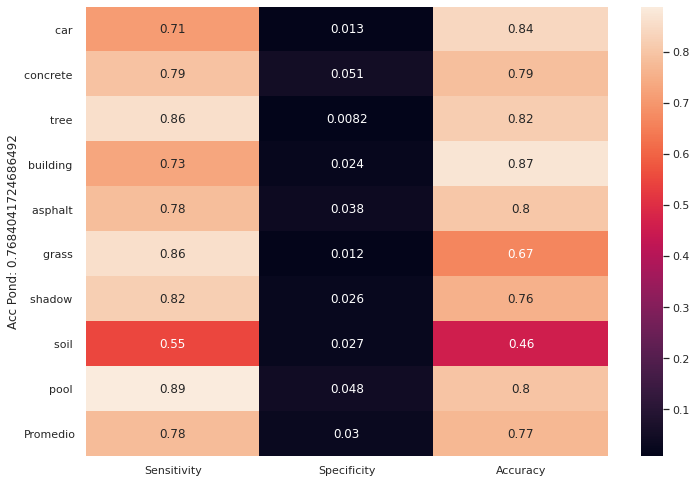

In [ ]:
sensitivity, specificity, acc = sens_spec(range(9), true_labels, predictions, pesos)
d = {'Sensitivity':sensitivity, 'Specificity':specificity, 'Accuracy':acc}
ind = clases.tolist()+['Promedio']
df = pd.DataFrame(d, index=ind)
index = df.index
precprom = sum([x*y for x,y in zip(acc,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)